CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Project - LSTM Notebook

### *Dominic Murphy and David Modjeska*

------

# Introduction

In [1]:
import math
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle

import tensorflow
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LSTM, regularizers
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import metrics
from keras import regularizers

%matplotlib inline
from IPython.display import Image, display, HTML

Using TensorFlow backend.


In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

# Modeling

*Note: some code has been adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*

#### Helper function to convert a dataframe for supervised learning

In [3]:
def series_to_supervised(data, n_in = 1, n_out = 1, drop_nan = True):
    columns = data.columns.values
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(columns[j] + '(t)' % ()) for j in range(n_vars)]
        else:
            names += [(columns[j] + '(t+%d)' % (i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    # drop rows with NaN values
    if drop_nan:
        agg.dropna(inplace = True)
    
    return agg

#### Load data

In [4]:
data = pd.read_csv('source_data.csv', parse_dates = ['date_key'])
print(data.shape)

(6551, 151)


#### Display first few rows of data

In [5]:
data.head()

,date_dayofyear,date_key,date_month,date_qtr,AU_IS_WORK_DAY,US_IS_WORK_DAY,CA_IS_WORK_DAY,UK_IS_WORK_DAY,IS_EURO,AU_FX,...,UK_FX_MA_090,UK_FX_MA_180,UK_FX_MA_365,temperature,AU_BMP_Ratio,CA_BMP_Ratio,UK_BMP_Ratio,CH_BMP_Ratio,JP_BMP_Ratio,time_index
0,3,2000-01-03,1,1,0,1,1,0,1,0.6591,...,1.628023,1.617005,1.617082,-0.943863,0.680107,0.784969,1.231594,3.715825,1.151735,0
1,4,2000-01-04,1,1,1,1,1,0,1,0.6562,...,1.627812,1.617446,1.617025,-0.940453,0.677115,0.782104,1.239163,3.658705,1.136206,1
2,5,2000-01-05,1,1,1,1,1,1,1,0.6550,...,1.627695,1.617946,1.616983,-0.940453,0.675876,0.782104,1.242570,3.649538,1.128760,2
3,6,2000-01-06,1,1,1,1,1,1,1,0.6540,...,1.627645,1.618471,1.616963,-0.936941,0.674845,0.779259,1.247112,3.652829,1.113523,3
4,7,2000-01-07,1,1,1,1,1,1,1,0.6548,...,1.627491,1.618938,1.616933,-0.936941,0.675670,0.782805,1.240223,3.672339,1.113735,4


#### Extract feature columns

In [6]:
feature_data = data.drop(['date_key', 'time_index'], axis = 1)
feature_cols = feature_data.columns
n_feature_cols = feature_data.shape[1]

## Helper functions

#### Calculate the latest start date among a set of features

In [7]:
euro_start_date = '2000-01-03'

def get_start_row_index(data, col_names):
    return(max([data[col].isnull().idxmin() for col in col_names]))

#### Reduce dimensionality of X by PCA

In [8]:
def pca_X(currency_name, X):
    
    # fit a PCA for exploration only
    n_pcs_total = int(np.round(X.shape[1] - 1))
    pca = PCA(n_components = n_pcs_total, svd_solver = 'full', random_state = 0)
    pca.fit(X)
    ratios = np.cumsum(pca.explained_variance_ratio_)
    
    # scree plot of variances explained
    plt.plot(1.0 - ratios)
    plt.title(currency_name + " - PCA cumulative variance explained")
    plt.xlabel("Number of components")
    plt.ylabel("% of variance not explained")
    plt.show()
    
    # computer number of components to use
    n_pcs_to_use = np.where(ratios >= 0.999)[0][0] + 1
    print('Cumulative variance explained by the first ' + str(n_pcs_to_use) + ' components: ' + 
          str(np.round(ratios[n_pcs_to_use], 4)))
    
    # fit a PCA and transform the data
    pca = PCA(n_components = n_pcs_to_use, svd_solver = 'arpack', random_state = 0)
    pca.fit(X)    
    X_pca = pd.DataFrame(pca.transform(X))
    
    return(X_pca, pca)

#### Helper function to manage data reduction by PCA

In [9]:
def do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed):
    if do_pca and (n_past_lags > 1):
        X = this_data_reframed.iloc[:, :-1]        
        X_pca, pca = pca_X(currency_name, X)
        this_data_pca = X_pca        
        this_data_pca['y'] = this_data_reframed.iloc[:, -1].values 

        my_display("<h4>Shape of train and test data after PCA</h4>")
        print('Reduced data shape: ' + str(this_data_pca.shape))
    else:
        this_data_pca = this_data_reframed
        pca = None
        
    return(this_data_pca, pca)

#### Helper function to reframe data for supervised training

In [10]:
def reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols):
    this_data_reframed = series_to_supervised(this_data_scaled, n_past_lags, n_future_lags) # X, y, and extra
    this_data_reframed_past = this_data_reframed.iloc[:, :(n_past_lags*n_these_cols)] # X = past = predictor
    this_data_reframed_future = this_data_reframed.iloc[:, -n_these_cols] # y = future = response
    this_data_reframed = pd.concat([this_data_reframed_past, this_data_reframed_future], axis = 1) # X and y
    
    print('Reframed data shape: ' + str(this_data_reframed.shape))
    return(this_data_reframed)

#### Prepare data for one model

In [11]:
n_past_lags = 7
n_future_lags = 7

def prep_model_data(currency_name, col_names, do_pca = False, verbose = 2):
    my_display("<h3>Prepare model data</h3>")
    
    # extract untransformed data
    n_these_cols = len(col_names)
    start_row_index = get_start_row_index(data, col_names)
    this_data = data[col_names].iloc[start_row_index:, :]
    n_these_rows = this_data.shape[0]
    
    # print data's time period
    print("Time period: " + str(data.date_key.dt.date[0]) + ' - ' + 
          str(data.date_key.dt.date[n_these_rows - 1]))
    
    # list untransformed model features
    if not do_pca:
        my_display("<h4>Features in Model</h4>")
        print(*col_names, sep = ', ')
        print()
    
    # scale data
    scaler = MinMaxScaler(feature_range = (0, 1))
    this_data_scaled = pd.DataFrame(scaler.fit_transform(this_data))
    this_data_scaled.columns = col_names
    print('Scaled data shape: ' + str(this_data_scaled.shape))
    
    # reframe data for supervised training
    this_data_reframed = reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols)

    # PCA X (if needed)
    this_data_pca, pca = do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed)
    
    # display first few rows of supervised data
    if (verbose == 2 and not do_pca):
        my_display("<h4>First few rows of supervised data</h4>")
        my_linespace()
        my_display_df(this_data_pca.head())
        my_linespace()

    # predict y naively as the previous day (and drop initial rows with resulting NaNs)
    yhat_naive = this_data_pca.iloc[:, -1].shift(n_future_lags)
    this_data_pca = this_data_pca.iloc[n_future_lags:, :]
    yhat_naive = yhat_naive.iloc[n_future_lags:, ]
        
    # split into train and test sets
    train, test, yhat_naive_train, yhat_naive_test = \
        train_test_split(this_data_pca, yhat_naive, test_size = 0.33, shuffle = False, random_state = 0)
    
    # split into input and outputs
    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features] (LSTM only)
    train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    if verbose == 2:
        my_display("<h4>Shape of train and test data</h4>")
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return(train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_these_cols)

#### Define the architecture of an LSTM

In [12]:
# design network
def define_lstm(train_X):
    model = Sequential()
    model.add(LSTM(200, input_shape = (train_X.shape[1], train_X.shape[2]),
                  bias_regularizer = regularizers.l2(0.002),
                  kernel_regularizer = regularizers.l2(0.002),
                  activity_regularizer = regularizers.l2(0.001)))
    model.add(Dense(1))
    
    adam = Adam(lr = 0.01, epsilon = 1e-8)
    model.compile(loss = 'mae', optimizer = adam)
    return(model)

#### Callback function to reduce the learning rate gradually during model training

In [13]:
def step_decay(epoch):
    initial_lrate = 0.01
    lrate = initial_lrate / math.pow(epoch + 1, .5)
    return lrate

#### Callback to support early stopping

In [14]:
early_stop = EarlyStopping (monitor = 'val_loss', min_delta = .00001, patience = 50, 
                            verbose = 0, mode = 'auto')

#### Helper function to plot training history

In [15]:
def plot_lstm_history(history):
    print()
    fig = plt.figure(figsize = (8, 6))
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()   

#### Helper function to instantiate and fit one model, and plot the feature importances

In [16]:
def define_fit_model(currency_name, train_X, test_X, train_y, test_y, do_pca = False, verbose = 2):
    my_display("<h3>Fit model</h3>") 
    # this_X = train_X if not do_pca else train_X.values # LSTM only
    
    n_epochs = 200    
    reduce_lr = LearningRateScheduler(step_decay)
    model_checkpoint = ModelCheckpoint(filepath = "./best_model.hdf5", monitor = 'val_loss', 
                                       verbose = 0, save_best_only = True, 
                                       save_weights_only = True, mode = 'auto', period = 1)
   
    # fit model
    model = define_lstm(train_X)    
    history = model.fit(train_X, train_y, epochs = n_epochs, batch_size = 32, 
                        validation_data = (test_X, test_y), verbose = verbose, shuffle = False,
                       callbacks = [reduce_lr, model_checkpoint, early_stop])
    
    # plot training history
    if verbose == 2:       
        plot_lstm_history(history)
        
    return(model)

#### Helper function to inverse transform the data

In [17]:
def inverse_transform(y, X, scaler, pca, n_cols):
    if pca is not None:
        X = pca.inverse_transform(X)
# LSTM only        
#     else:
#         X = X.values
        
    inv_y = np.concatenate((y, X[:, 1:n_cols]), axis = 1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    
    return(inv_y)

#### Helper function to plot histogram of prediction errors

In [18]:
def vis_error(currency_name, error):
    fig, ax = plt.subplots(figsize = (8.5, 4))
    sns.distplot(a = error, kde = False, bins = 40, hist_kws = {'alpha': 0.8}, ax = ax)
    ax.set_xlabel('Error')
    ax.set_ylabel('Frequency')
    ax.set_title(currency_name + ' - Distribution of test RMSE')
    plt.show()

#### Helper function to plot predicted vs. actual percentage change

In [19]:
def vis_percentage_pred(currency_name, y_pred_perc ,y_actual_perc, verbose=2):
    df = pd.DataFrame({'Predicted': y_pred_perc,'Actual'  : y_actual_perc})
    
    is_green = lambda a, b: (((a <= 0) and (b <=0)) or ((a > 0) and (b > 0))) * 1
    df['isGreen'] = df.Actual.combine(df.Predicted, func=is_green)
    
    fig, ax = plt.subplots(figsize = (21, 6))
    ax.scatter(df[df.isGreen==1].Predicted ,df[df.isGreen==1].Actual , edgecolors=(0, 0, 0), 
               alpha=.4, c='g', label='Profit') #cmap
    ax.scatter(df[df.isGreen==0].Predicted ,df[df.isGreen==0].Actual , edgecolors=(0, 0, 0), 
               alpha=.4, c='r', label='Loss')
    plt.axhline(y=0.0, color='grey', linestyle='-')
    plt.axvline(x=0.0, color='grey', linestyle='-')
    ax.set_xlabel('Predicted (% Change)')
    ax.set_ylabel('Actual  (% Change)') 
    ax.set_title(currency_name + ' - Predicted vs. Actual (% Change)')
    plt.legend()
    
    plt.show()

#### Score a model using RMSE with test data

In [20]:
no_score = None

def score_model(currency_name, best_model, train_X, test_X, train_y, test_y, 
                scaler, pca, inv_yhat_naive, n_cols, verbose = 2):
    my_display("<h3>Score model on test data</h3>")
    do_pca = pca is not None
        
    # reload best model (LSTM only)
    best_model = define_lstm(train_X)
    best_model.load_weights('./best_model.hdf5')    
    
    # make a prediction on test data (LSTM only)
    yhat = best_model.predict(test_X).reshape(-1, 1)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert/reverse/undo scaling for forecast
    inv_yhat = inverse_transform(yhat, test_X, scaler, pca, n_cols)    
    
    # invert scaling for actual
    test_y = test_y.values.reshape((len(test_y), 1))
    inv_y = inverse_transform(test_y, test_X, scaler, pca, n_cols)
    
    # invert scaling for y-hat naive
    inv_yhat_naive = inv_yhat_naive.values.reshape((len(inv_yhat_naive), 1))  
    inv_yhat_naive = inverse_transform(inv_yhat_naive, test_X, scaler, pca, n_cols)    
    
    # naive model
    my_display("<h4>RMSE from naive model that always predicts the previous week's rate</h4>")
    naive_rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_naive))
    print("RMSE: " + str(np.round(naive_rmse, 5)))
    
    # calculate RMSE on test data
    my_display("<h4>RMSE from fitted model</h4>")
    test_rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print("RMSE: " + str(np.round(test_rmse, 5)))

    # calculate relative prediction error percentages
    y_pred_perc   = 100 * (1 - (inv_yhat/inv_yhat_naive))
    y_actual_perc = 100 * (1 - (inv_y   /inv_yhat_naive))
    y_perc_error  = (np.abs(y_pred_perc - y_actual_perc)).mean()    
    
    # visualize relative prediction error percentages
    if verbose == 2 and do_pca:
        vis_error(currency_name, inv_yhat)
        vis_percentage_pred(currency_name, y_pred_perc,y_actual_perc)    
    
    return(naive_rmse, test_rmse)

#### Top-level function to create, fit, and score one model

In [21]:
def do_one_model(currency_name, feature_col_names, do_pca = False, verbose = 2):
    train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_features = \
        prep_model_data(currency_name, feature_col_names, do_pca, verbose)
    best_model = define_fit_model(currency_name, train_X, test_X, train_y, test_y, do_pca, verbose)
    naive_rmse, test_rmse = score_model(currency_name, best_model, train_X, test_X, train_y, test_y, 
                                        scaler, pca, yhat_naive_test, n_features, verbose = verbose)
    
    return(naive_rmse, test_rmse)

#### Create a dataframe to accumulate modeling results for all currencies

In [22]:
all_results = pd.DataFrame()

#### Accumulate results from one model

In [23]:
def accum_results(all_results, currency, naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse):
    results = pd.DataFrame({'Currency': currency, 
                              'Naive': naive_rmse, 
                              'FX Only': fx_rmse, 
                              'FX + Features': fx_features_rmse,
                              'All Features': fx_all_rmse},
                            index = range(1))
    all_results = all_results.append(results).reset_index(drop = True)
    return(all_results)

## Australia

### FX rates only

Time period: 2000-01-03 - 2017-12-09


AU_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


AU_FX(t-7),AU_FX(t-6),AU_FX(t-5),AU_FX(t-4),AU_FX(t-3),AU_FX(t-2),AU_FX(t-1),AU_FX(t+6)
0.284447,0.279768,0.277832,0.276218,0.277509,0.278208,0.278907,0.295041
0.279768,0.277832,0.276218,0.277509,0.278208,0.278907,0.279606,0.294369
0.277832,0.276218,0.277509,0.278208,0.278907,0.279606,0.281865,0.292352
0.276218,0.277509,0.278208,0.278907,0.279606,0.281865,0.282349,0.291384
0.277509,0.278208,0.278907,0.279606,0.281865,0.282349,0.299935,0.296547


(4375, 1, 7) (4375,) (2156, 1, 7) (2156,)


Train on 4375 samples, validate on 2156 samples
Epoch 1/200
1s - loss: 0.1821 - val_loss: 0.1282
Epoch 2/200
1s - loss: 0.0877 - val_loss: 0.1333
Epoch 3/200
1s - loss: 0.0760 - val_loss: 0.1015
Epoch 4/200
1s - loss: 0.0736 - val_loss: 0.0888
Epoch 5/200
1s - loss: 0.0658 - val_loss: 0.0772
Epoch 6/200
1s - loss: 0.0550 - val_loss: 0.0748
Epoch 7/200
1s - loss: 0.0492 - val_loss: 0.0732
Epoch 8/200
1s - loss: 0.0473 - val_loss: 0.0649
Epoch 9/200
1s - loss: 0.0441 - val_loss: 0.0621
Epoch 10/200
1s - loss: 0.0426 - val_loss: 0.0614
Epoch 11/200
1s - loss: 0.0406 - val_loss: 0.0591
Epoch 12/200
1s - loss: 0.0393 - val_loss: 0.0576
Epoch 13/200
1s - loss: 0.0382 - val_loss: 0.0586
Epoch 14/200
1s - loss: 0.0386 - val_loss: 0.0596
Epoch 15/200
1s - loss: 0.0376 - val_loss: 0.0614
Epoch 16/200
1s - loss: 0.0378 - val_loss: 0.0608
Epoch 17/200
1s - loss: 0.0372 - val_loss: 0.0607
Epoch 18/200
1s - loss: 0.0361 - val_loss: 0.0602
Epoch 19/200
1s - loss: 0.0354 - val_loss: 0.0577
Epoch 20/20

1s - loss: 0.0234 - val_loss: 0.0419
Epoch 164/200
1s - loss: 0.0234 - val_loss: 0.0421
Epoch 165/200
1s - loss: 0.0234 - val_loss: 0.0421
Epoch 166/200
1s - loss: 0.0234 - val_loss: 0.0425
Epoch 167/200
1s - loss: 0.0234 - val_loss: 0.0428
Epoch 168/200
1s - loss: 0.0234 - val_loss: 0.0426
Epoch 169/200
1s - loss: 0.0233 - val_loss: 0.0426
Epoch 170/200
1s - loss: 0.0233 - val_loss: 0.0416
Epoch 171/200
1s - loss: 0.0232 - val_loss: 0.0427
Epoch 172/200
1s - loss: 0.0233 - val_loss: 0.0422
Epoch 173/200
1s - loss: 0.0232 - val_loss: 0.0416
Epoch 174/200
1s - loss: 0.0233 - val_loss: 0.0422
Epoch 175/200
1s - loss: 0.0233 - val_loss: 0.0419
Epoch 176/200
1s - loss: 0.0232 - val_loss: 0.0426
Epoch 177/200
1s - loss: 0.0233 - val_loss: 0.0425
Epoch 178/200
1s - loss: 0.0231 - val_loss: 0.0418
Epoch 179/200
1s - loss: 0.0231 - val_loss: 0.0415
Epoch 180/200
1s - loss: 0.0232 - val_loss: 0.0417
Epoch 181/200
1s - loss: 0.0232 - val_loss: 0.0430
Epoch 182/200
1s - loss: 0.0232 - val_loss: 0

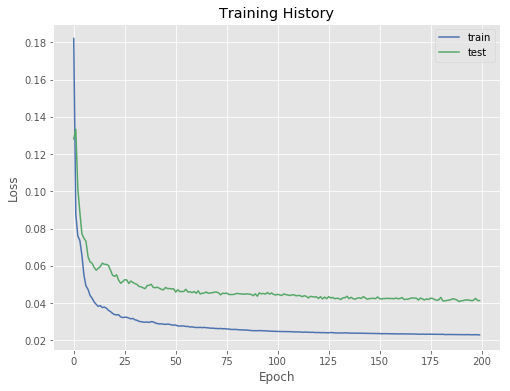

RMSE: 0.01105


RMSE: 0.02661


In [24]:
naive_rmse, fx_rmse = do_one_model('AUD', feature_col_names = ['AU_FX'], verbose = 2)

### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


AU_FX, AU_POP, GOLD

Scaled data shape: (6551, 3)
Reframed data shape: (6538, 22)


AU_FX(t-7),AU_POP(t-7),GOLD(t-7),AU_FX(t-6),AU_POP(t-6),GOLD(t-6),AU_FX(t-5),AU_POP(t-5),GOLD(t-5),AU_FX(t-4),AU_POP(t-4),GOLD(t-4),AU_FX(t-3),AU_POP(t-3),GOLD(t-3),AU_FX(t-2),AU_POP(t-2),GOLD(t-2),AU_FX(t-1),AU_POP(t-1),GOLD(t-1),AU_FX(t+6)
0.284447,0.395753,0.017248,0.279768,0.396050,0.015459,0.277832,0.396347,0.015490,0.276218,0.396644,0.014422,0.277509,0.396941,0.015429,0.278208,0.397238,0.015368,0.278907,0.397535,0.015307,0.295041
0.279768,0.396050,0.015459,0.277832,0.396347,0.015490,0.276218,0.396644,0.014422,0.277509,0.396941,0.015429,0.278208,0.397238,0.015368,0.278907,0.397535,0.015307,0.279606,0.397832,0.015246,0.294369
0.277832,0.396347,0.015490,0.276218,0.396644,0.014422,0.277509,0.396941,0.015429,0.278208,0.397238,0.015368,0.278907,0.397535,0.015307,0.279606,0.397832,0.015246,0.281865,0.398129,0.015246,0.292352
0.276218,0.396644,0.014422,0.277509,0.396941,0.015429,0.278208,0.397238,0.015368,0.278907,0.397535,0.015307,0.279606,0.397832,0.015246,0.281865,0.398129,0.015246,0.282349,0.398425,0.015581,0.291384
0.277509,0.396941,0.015429,0.278208,0.397238,0.015368,0.278907,0.397535,0.015307,0.279606,0.397832,0.015246,0.281865,0.398129,0.015246,0.282349,0.398425,0.015581,0.299935,0.398722,0.015551,0.296547


(4375, 1, 21) (4375,) (2156, 1, 21) (2156,)


Train on 4375 samples, validate on 2156 samples
Epoch 1/200
1s - loss: 0.2227 - val_loss: 0.3128
Epoch 2/200
1s - loss: 0.1286 - val_loss: 0.2197
Epoch 3/200
1s - loss: 0.0964 - val_loss: 0.2075
Epoch 4/200
1s - loss: 0.1099 - val_loss: 0.2068
Epoch 5/200
1s - loss: 0.1078 - val_loss: 0.2106
Epoch 6/200
1s - loss: 0.1173 - val_loss: 0.2027
Epoch 7/200
1s - loss: 0.1188 - val_loss: 0.1815
Epoch 8/200
1s - loss: 0.1104 - val_loss: 0.1796
Epoch 9/200
1s - loss: 0.0994 - val_loss: 0.1916
Epoch 10/200
1s - loss: 0.0854 - val_loss: 0.1638
Epoch 11/200
1s - loss: 0.0778 - val_loss: 0.2109
Epoch 12/200
1s - loss: 0.0778 - val_loss: 0.1939
Epoch 13/200
1s - loss: 0.0705 - val_loss: 0.1215
Epoch 14/200
1s - loss: 0.0710 - val_loss: 0.2158
Epoch 15/200
1s - loss: 0.0739 - val_loss: 0.1317
Epoch 16/200
1s - loss: 0.0590 - val_loss: 0.1607
Epoch 17/200
1s - loss: 0.0593 - val_loss: 0.1038
Epoch 18/200
1s - loss: 0.0580 - val_loss: 0.1151
Epoch 19/200
1s - loss: 0.0595 - val_loss: 0.1671
Epoch 20/20

1s - loss: 0.0304 - val_loss: 0.0595
Epoch 164/200
1s - loss: 0.0306 - val_loss: 0.0604
Epoch 165/200
1s - loss: 0.0310 - val_loss: 0.0572
Epoch 166/200
1s - loss: 0.0313 - val_loss: 0.0619
Epoch 167/200
1s - loss: 0.0311 - val_loss: 0.0611
Epoch 168/200
1s - loss: 0.0308 - val_loss: 0.0643
Epoch 169/200
1s - loss: 0.0305 - val_loss: 0.0645
Epoch 170/200
1s - loss: 0.0305 - val_loss: 0.0644
Epoch 171/200
1s - loss: 0.0309 - val_loss: 0.0651
Epoch 172/200
1s - loss: 0.0322 - val_loss: 0.0701
Epoch 173/200
1s - loss: 0.0333 - val_loss: 0.0715
Epoch 174/200
1s - loss: 0.0340 - val_loss: 0.0651



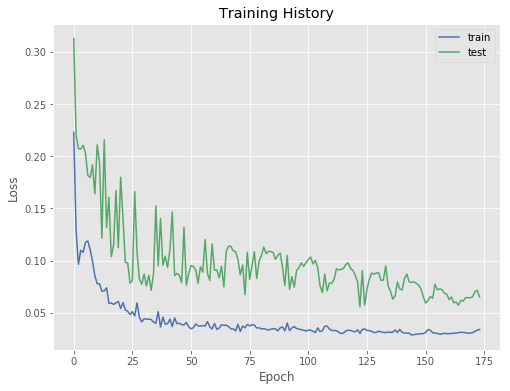

RMSE: 0.01105


RMSE: 0.03426


In [25]:
naive_rmse, fx_features_rmse = do_one_model('AUD', feature_col_names = ['AU_FX', 'AU_POP', 'GOLD'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


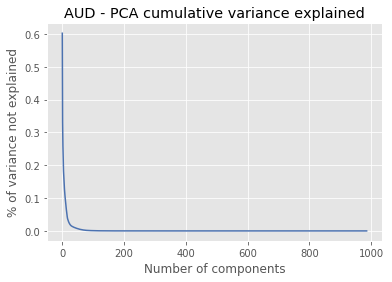

Cumulative variance explained by the first 94 components: 0.9991


Reduced data shape: (4708, 95)


(3149, 1, 94) (3149,) (1552, 1, 94) (1552,)


Train on 3149 samples, validate on 1552 samples
Epoch 1/200
0s - loss: 0.4812 - val_loss: 0.5997
Epoch 2/200
0s - loss: 0.2706 - val_loss: 1.0265
Epoch 3/200
0s - loss: 0.2894 - val_loss: 0.6039
Epoch 4/200
0s - loss: 0.2253 - val_loss: 0.6680
Epoch 5/200
0s - loss: 0.2739 - val_loss: 0.7925
Epoch 6/200
0s - loss: 0.2220 - val_loss: 0.4430
Epoch 7/200
0s - loss: 0.1611 - val_loss: 0.5109
Epoch 8/200
0s - loss: 0.1283 - val_loss: 0.5079
Epoch 9/200
0s - loss: 0.1448 - val_loss: 0.3070
Epoch 10/200
0s - loss: 0.1365 - val_loss: 0.5208
Epoch 11/200
0s - loss: 0.1608 - val_loss: 0.2837
Epoch 12/200
0s - loss: 0.1197 - val_loss: 0.3050
Epoch 13/200
0s - loss: 0.1094 - val_loss: 0.3692
Epoch 14/200
0s - loss: 0.0944 - val_loss: 0.2499
Epoch 15/200
0s - loss: 0.0936 - val_loss: 0.2894
Epoch 16/200
0s - loss: 0.0953 - val_loss: 0.2787
Epoch 17/200
0s - loss: 0.1150 - val_loss: 0.3476
Epoch 18/200
0s - loss: 0.0977 - val_loss: 0.2488
Epoch 19/200
0s - loss: 0.1006 - val_loss: 0.2763
Epoch 20/20

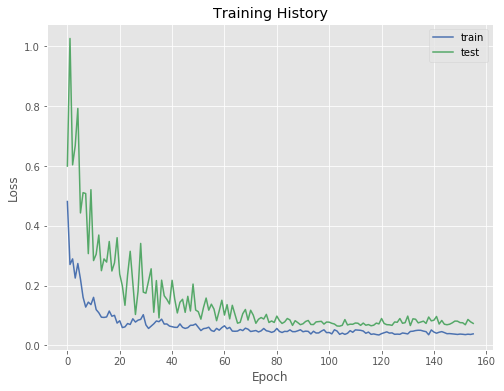

RMSE: 0.01038


RMSE: 0.03466


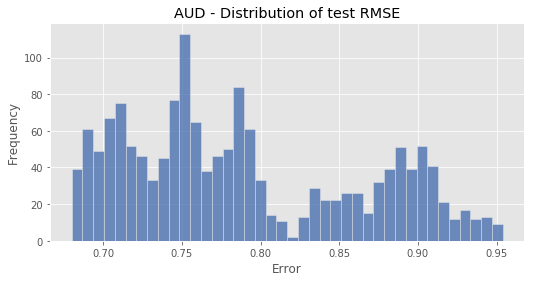

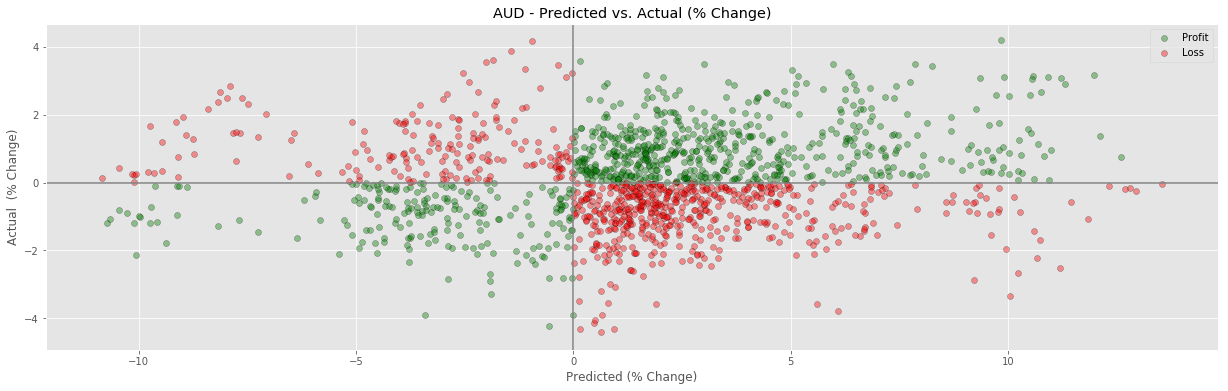

In [26]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('AU_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('AUD', feature_col_names = ['AU_FX'] + cols, do_pca = True)

In [27]:
all_results = accum_results(all_results, 'AUD', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## Canada

### FX rates only

In [28]:
naive_rmse, fx_rmse = do_one_model('CAD', feature_col_names = ['CA_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


CA_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


RMSE: 0.00864


RMSE: 0.01523


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


CA_FX, CA_GDP

Scaled data shape: (6551, 2)
Reframed data shape: (6538, 15)


CA_FX(t-7),CA_GDP(t-7),CA_FX(t-6),CA_GDP(t-6),CA_FX(t-5),CA_GDP(t-5),CA_FX(t-4),CA_GDP(t-4),CA_FX(t-3),CA_GDP(t-3),CA_FX(t-2),CA_GDP(t-2),CA_FX(t-1),CA_GDP(t-1),CA_FX(t+6)
0.151440,1.000000,0.146078,0.998836,0.146078,0.997672,0.140755,0.996508,0.147389,0.995344,0.145272,0.994180,0.143161,0.993017,0.148029
0.146078,0.998836,0.146078,0.997672,0.140755,0.996508,0.147389,0.995344,0.145272,0.994180,0.143161,0.993017,0.141056,0.991853,0.147945
0.146078,0.997672,0.140755,0.996508,0.147389,0.995344,0.145272,0.994180,0.143161,0.993017,0.141056,0.991853,0.140855,0.990689,0.147692
0.140755,0.996508,0.147389,0.995344,0.145272,0.994180,0.143161,0.993017,0.141056,0.991853,0.140855,0.990689,0.142860,0.989525,0.145171
0.147389,0.995344,0.145272,0.994180,0.143161,0.993017,0.141056,0.991853,0.140855,0.990689,0.142860,0.989525,0.148400,0.988361,0.149513


(4375, 1, 14) (4375,) (2156, 1, 14) (2156,)


Train on 4375 samples, validate on 2156 samples
Epoch 1/200
1s - loss: 0.2051 - val_loss: 0.2913
Epoch 2/200
1s - loss: 0.1201 - val_loss: 0.1886
Epoch 3/200
1s - loss: 0.0986 - val_loss: 0.1983
Epoch 4/200
1s - loss: 0.1050 - val_loss: 0.1997
Epoch 5/200
1s - loss: 0.1022 - val_loss: 0.2344
Epoch 6/200
1s - loss: 0.1343 - val_loss: 0.1931
Epoch 7/200
1s - loss: 0.1240 - val_loss: 0.1720
Epoch 8/200
1s - loss: 0.1176 - val_loss: 0.1528
Epoch 9/200
1s - loss: 0.1072 - val_loss: 0.1479
Epoch 10/200
1s - loss: 0.1035 - val_loss: 0.1460
Epoch 11/200
1s - loss: 0.0978 - val_loss: 0.1410
Epoch 12/200
1s - loss: 0.0942 - val_loss: 0.1385
Epoch 13/200
1s - loss: 0.0963 - val_loss: 0.1384
Epoch 14/200
1s - loss: 0.0944 - val_loss: 0.1438
Epoch 15/200
1s - loss: 0.0887 - val_loss: 0.1227
Epoch 16/200
1s - loss: 0.0835 - val_loss: 0.1310
Epoch 17/200
1s - loss: 0.0784 - val_loss: 0.1124
Epoch 18/200
1s - loss: 0.0720 - val_loss: 0.0938
Epoch 19/200
1s - loss: 0.0709 - val_loss: 0.1062
Epoch 20/20

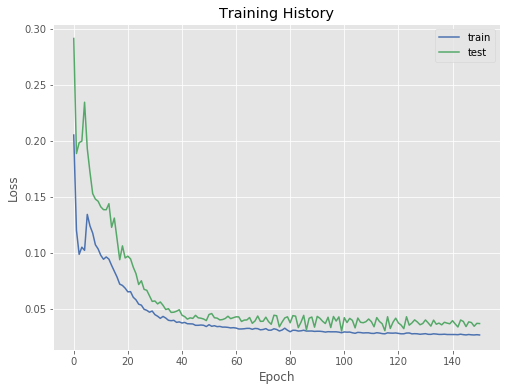

RMSE: 0.00864


RMSE: 0.01399


In [29]:
naive_rmse, fx_features_rmse = do_one_model('CAD', feature_col_names =  ['CA_FX', 'CA_GDP'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 139)
Reframed data shape: (4708, 974)


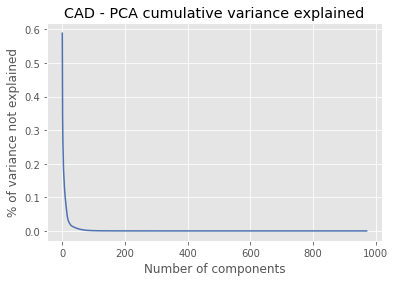

Cumulative variance explained by the first 93 components: 0.9991


Reduced data shape: (4708, 94)


(3149, 1, 93) (3149,) (1552, 1, 93) (1552,)


Train on 3149 samples, validate on 1552 samples
Epoch 1/200
1s - loss: 0.5914 - val_loss: 0.6026
Epoch 2/200
0s - loss: 0.3695 - val_loss: 1.4459
Epoch 3/200
0s - loss: 0.2741 - val_loss: 0.7139
Epoch 4/200
0s - loss: 0.2085 - val_loss: 0.8656
Epoch 5/200
0s - loss: 0.1588 - val_loss: 0.3445
Epoch 6/200
0s - loss: 0.1766 - val_loss: 0.2996
Epoch 7/200
0s - loss: 0.1778 - val_loss: 0.1953
Epoch 8/200
0s - loss: 0.1525 - val_loss: 0.3179
Epoch 9/200
0s - loss: 0.1274 - val_loss: 0.2722
Epoch 10/200
0s - loss: 0.1073 - val_loss: 0.3732
Epoch 11/200
0s - loss: 0.0957 - val_loss: 0.1820
Epoch 12/200
0s - loss: 0.0944 - val_loss: 0.1025
Epoch 13/200
0s - loss: 0.0916 - val_loss: 0.1270
Epoch 14/200
0s - loss: 0.1101 - val_loss: 0.1055
Epoch 15/200
0s - loss: 0.1150 - val_loss: 0.1815
Epoch 16/200
0s - loss: 0.0873 - val_loss: 0.1290
Epoch 17/200
0s - loss: 0.0685 - val_loss: 0.0850
Epoch 18/200
0s - loss: 0.0666 - val_loss: 0.1498
Epoch 19/200
0s - loss: 0.0706 - val_loss: 0.1440
Epoch 20/20

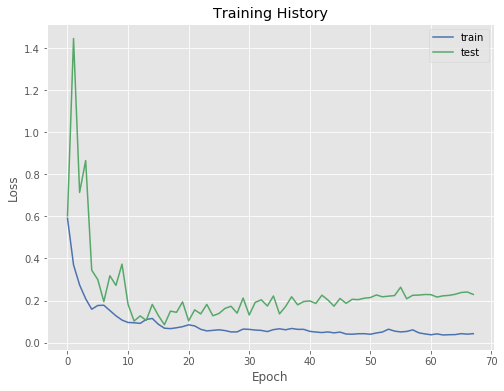

RMSE: 0.00873


RMSE: 0.02792


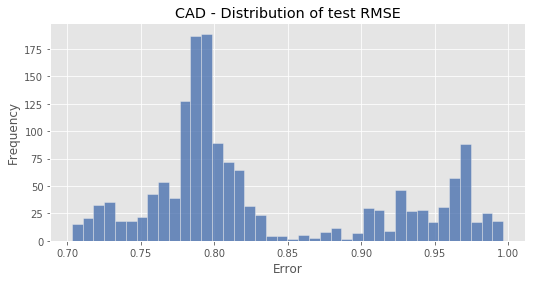

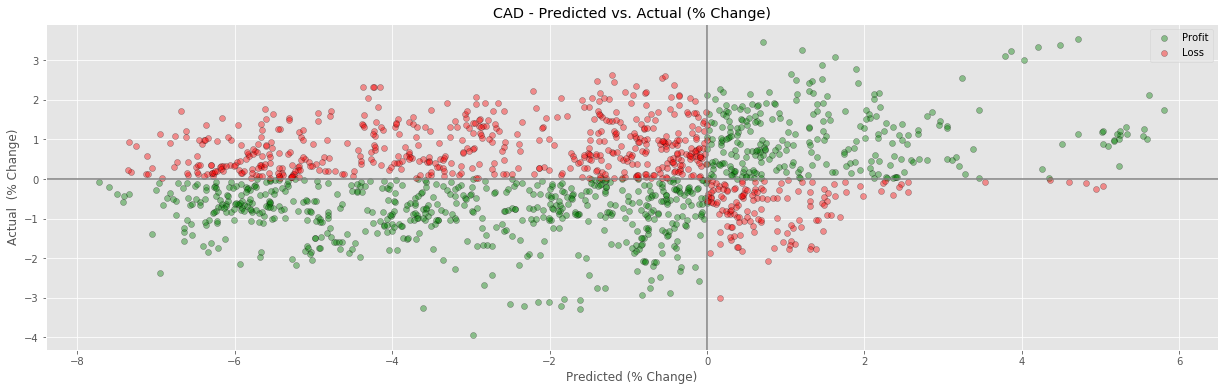

In [30]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CA_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('CAD', feature_col_names = ['CA_FX'] + cols, do_pca = True)

In [31]:
all_results = accum_results(all_results, 'CAD', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## EU

### FX rates only

In [32]:
naive_rmse, fx_rmse = do_one_model('EUR', feature_col_names = ['EU_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


EU_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


RMSE: 0.01378


RMSE: 0.02098


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


EU_FX, CH_FX, DE_INT_TB, US_INT_TB, US_GDP

Scaled data shape: (6551, 5)
Reframed data shape: (6538, 36)


EU_FX(t-7),CH_FX(t-7),DE_INT_TB(t-7),US_INT_TB(t-7),US_GDP(t-7),EU_FX(t-6),CH_FX(t-6),DE_INT_TB(t-6),US_INT_TB(t-6),US_GDP(t-6),EU_FX(t-5),CH_FX(t-5),DE_INT_TB(t-5),US_INT_TB(t-5),US_GDP(t-5),EU_FX(t-4),CH_FX(t-4),DE_INT_TB(t-4),US_INT_TB(t-4),US_GDP(t-4),EU_FX(t-3),CH_FX(t-3),DE_INT_TB(t-3),US_INT_TB(t-3),US_GDP(t-3),EU_FX(t-2),CH_FX(t-2),DE_INT_TB(t-2),US_INT_TB(t-2),US_GDP(t-2),EU_FX(t-1),CH_FX(t-1),DE_INT_TB(t-1),US_INT_TB(t-1),US_GDP(t-1),EU_FX(t+6)
0.243540,0.777068,0.641026,0.864422,0.608791,0.263437,0.754884,0.641026,0.865626,0.613187,0.266796,0.751324,0.641026,0.866831,0.617582,0.265375,0.752602,0.641026,0.868035,0.621978,0.261499,0.760179,0.641026,0.869240,0.626374,0.259690,0.762644,0.641026,0.870444,0.630769,0.257881,0.765109,0.641026,0.871649,0.635165,0.239750
0.263437,0.754884,0.641026,0.865626,0.613187,0.266796,0.751324,0.641026,0.866831,0.617582,0.265375,0.752602,0.641026,0.868035,0.621978,0.261499,0.760179,0.641026,0.869240,0.626374,0.259690,0.762644,0.641026,0.870444,0.630769,0.257881,0.765109,0.641026,0.871649,0.635165,0.256072,0.767573,0.641026,0.872853,0.639560,0.239599
0.266796,0.751324,0.641026,0.866831,0.617582,0.265375,0.752602,0.641026,0.868035,0.621978,0.261499,0.760179,0.641026,0.869240,0.626374,0.259690,0.762644,0.641026,0.870444,0.630769,0.257881,0.765109,0.641026,0.871649,0.635165,0.256072,0.767573,0.641026,0.872853,0.639560,0.265116,0.758536,0.641026,0.874057,0.643956,0.239147
0.265375,0.752602,0.641026,0.868035,0.621978,0.261499,0.760179,0.641026,0.869240,0.626374,0.259690,0.762644,0.641026,0.870444,0.630769,0.257881,0.765109,0.641026,0.871649,0.635165,0.256072,0.767573,0.641026,0.872853,0.639560,0.265116,0.758536,0.641026,0.874057,0.643956,0.259819,0.763557,0.641026,0.875262,0.648352,0.238372
0.261499,0.760179,0.641026,0.869240,0.626374,0.259690,0.762644,0.641026,0.870444,0.630769,0.257881,0.765109,0.641026,0.871649,0.635165,0.256072,0.767573,0.641026,0.872853,0.639560,0.265116,0.758536,0.641026,0.874057,0.643956,0.259819,0.763557,0.641026,0.875262,0.648352,0.258398,0.767847,0.641026,0.876466,0.652747,0.240698


(4375, 1, 35) (4375,) (2156, 1, 35) (2156,)


Train on 4375 samples, validate on 2156 samples
Epoch 1/200
1s - loss: 0.2524 - val_loss: 0.1476
Epoch 2/200
1s - loss: 0.1196 - val_loss: 0.1760
Epoch 3/200
1s - loss: 0.1134 - val_loss: 0.1850
Epoch 4/200
1s - loss: 0.1397 - val_loss: 0.2924
Epoch 5/200
1s - loss: 0.1454 - val_loss: 0.2616
Epoch 6/200
1s - loss: 0.1241 - val_loss: 0.2483
Epoch 7/200
1s - loss: 0.1222 - val_loss: 0.2363
Epoch 8/200
1s - loss: 0.1199 - val_loss: 0.2165
Epoch 9/200
1s - loss: 0.1233 - val_loss: 0.2092
Epoch 10/200
1s - loss: 0.1107 - val_loss: 0.1987
Epoch 11/200
1s - loss: 0.1061 - val_loss: 0.1853
Epoch 12/200
1s - loss: 0.0883 - val_loss: 0.1660
Epoch 13/200
1s - loss: 0.0908 - val_loss: 0.1873
Epoch 14/200
1s - loss: 0.0944 - val_loss: 0.1694
Epoch 15/200
1s - loss: 0.0920 - val_loss: 0.1373
Epoch 16/200
1s - loss: 0.0911 - val_loss: 0.1553
Epoch 17/200
1s - loss: 0.1028 - val_loss: 0.1121
Epoch 18/200
1s - loss: 0.0853 - val_loss: 0.1131
Epoch 19/200
1s - loss: 0.0836 - val_loss: 0.1188
Epoch 20/20

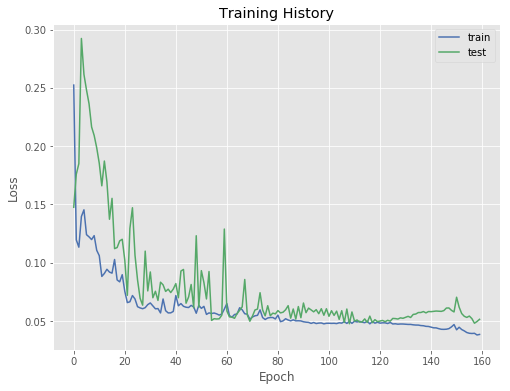

RMSE: 0.01378


RMSE: 0.03526


In [33]:
naive_rmse, fx_features_rmse = do_one_model('EUR', feature_col_names = \
    ['EU_FX', 'CH_FX', 'DE_INT_TB', 'US_INT_TB', 'US_GDP'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


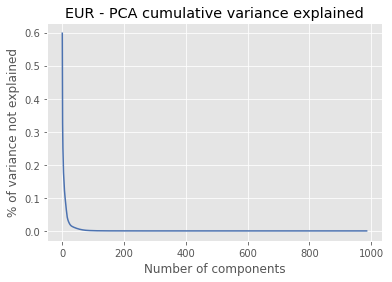

Cumulative variance explained by the first 93 components: 0.999


Reduced data shape: (4708, 94)


(3149, 1, 93) (3149,) (1552, 1, 93) (1552,)


Train on 3149 samples, validate on 1552 samples
Epoch 1/200
1s - loss: 0.5098 - val_loss: 0.5989
Epoch 2/200
0s - loss: 0.2937 - val_loss: 0.9111
Epoch 3/200
0s - loss: 0.2312 - val_loss: 0.2820
Epoch 4/200
0s - loss: 0.2304 - val_loss: 0.3851
Epoch 5/200
0s - loss: 0.1838 - val_loss: 0.1798
Epoch 6/200
0s - loss: 0.1351 - val_loss: 0.5766
Epoch 7/200
0s - loss: 0.1680 - val_loss: 0.1476
Epoch 8/200
0s - loss: 0.1241 - val_loss: 0.1597
Epoch 9/200
0s - loss: 0.1563 - val_loss: 0.1503
Epoch 10/200
0s - loss: 0.1341 - val_loss: 0.1960
Epoch 11/200
0s - loss: 0.1130 - val_loss: 0.1782
Epoch 12/200
0s - loss: 0.1062 - val_loss: 0.1044
Epoch 13/200
0s - loss: 0.1193 - val_loss: 0.1010
Epoch 14/200
0s - loss: 0.0994 - val_loss: 0.1945
Epoch 15/200
0s - loss: 0.0970 - val_loss: 0.1945
Epoch 16/200
0s - loss: 0.0784 - val_loss: 0.1166
Epoch 17/200
0s - loss: 0.0979 - val_loss: 0.2090
Epoch 18/200
0s - loss: 0.0974 - val_loss: 0.1783
Epoch 19/200
0s - loss: 0.0866 - val_loss: 0.1602
Epoch 20/20

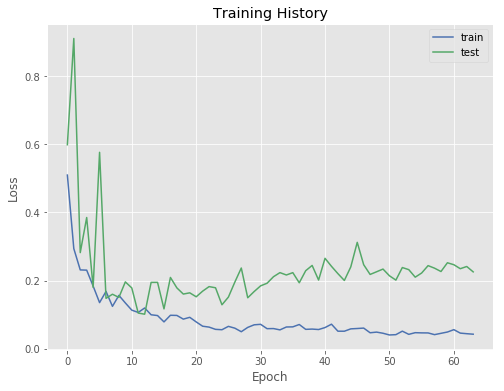

RMSE: 0.01347


RMSE: 0.03378


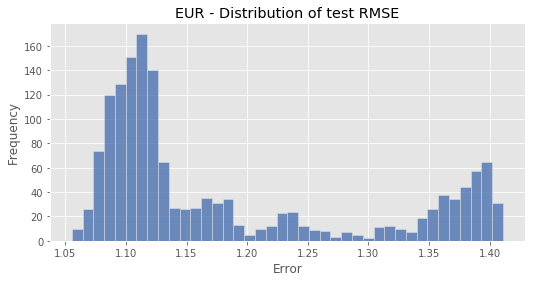

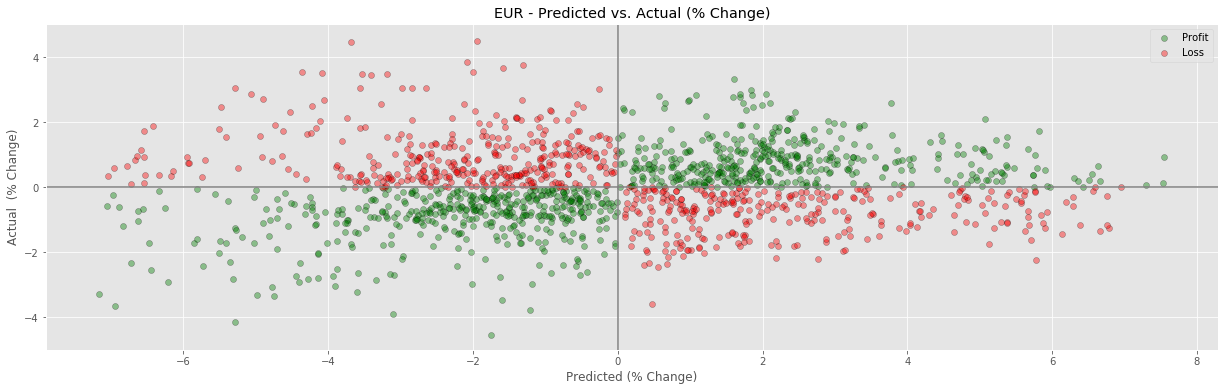

In [34]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('EU_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('EUR', feature_col_names = ['EU_FX'] + cols, do_pca = True)

In [35]:
all_results = accum_results(all_results, 'EUR', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## Japan

### FX rates only

In [36]:
naive_rmse, fx_rmse = do_one_model('JPY', feature_col_names = ['JP_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


JP_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


RMSE: 0.00013


RMSE: 0.00023


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


JP_FX, JP_GDP, JP_UR, JP_CPI

Scaled data shape: (6551, 4)
Reframed data shape: (6538, 29)


JP_FX(t-7),JP_GDP(t-7),JP_UR(t-7),JP_CPI(t-7),JP_FX(t-6),JP_GDP(t-6),JP_UR(t-6),JP_CPI(t-6),JP_FX(t-5),JP_GDP(t-5),JP_UR(t-5),JP_CPI(t-5),JP_FX(t-4),JP_GDP(t-4),JP_UR(t-4),JP_CPI(t-4),JP_FX(t-3),JP_GDP(t-3),JP_UR(t-3),JP_CPI(t-3),JP_FX(t-2),JP_GDP(t-2),JP_UR(t-2),JP_CPI(t-2),JP_FX(t-1),JP_GDP(t-1),JP_UR(t-1),JP_CPI(t-1),JP_FX(t+6)
0.416969,0.941484,0.691880,0.261186,0.394057,0.938837,0.692992,0.262747,0.383072,0.936190,0.694105,0.264308,0.360591,0.933543,0.695217,0.265869,0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.352097
0.394057,0.938837,0.692992,0.262747,0.383072,0.936190,0.694105,0.264308,0.360591,0.933543,0.695217,0.265869,0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.359186,0.922954,0.699666,0.272112,0.353050
0.383072,0.936190,0.694105,0.264308,0.360591,0.933543,0.695217,0.265869,0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.359186,0.922954,0.699666,0.272112,0.346653,0.920307,0.700779,0.273673,0.355918
0.360591,0.933543,0.695217,0.265869,0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.359186,0.922954,0.699666,0.272112,0.346653,0.920307,0.700779,0.273673,0.351736,0.917659,0.701891,0.275234,0.357473
0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.359186,0.922954,0.699666,0.272112,0.346653,0.920307,0.700779,0.273673,0.351736,0.917659,0.701891,0.275234,0.346653,0.915012,0.703003,0.276795,0.356540


(4375, 1, 28) (4375,) (2156, 1, 28) (2156,)


Train on 4375 samples, validate on 2156 samples
Epoch 1/200
1s - loss: 0.2531 - val_loss: 0.4403
Epoch 2/200
1s - loss: 0.1021 - val_loss: 0.5022
Epoch 3/200
1s - loss: 0.1159 - val_loss: 0.4604
Epoch 4/200
1s - loss: 0.1095 - val_loss: 0.6012
Epoch 5/200
1s - loss: 0.1054 - val_loss: 0.4457
Epoch 6/200
1s - loss: 0.0960 - val_loss: 0.4430
Epoch 7/200
1s - loss: 0.1016 - val_loss: 0.5748
Epoch 8/200
1s - loss: 0.1298 - val_loss: 0.4654
Epoch 9/200
1s - loss: 0.1293 - val_loss: 0.4462
Epoch 10/200
1s - loss: 0.1371 - val_loss: 0.4863
Epoch 11/200
1s - loss: 0.1333 - val_loss: 0.3818
Epoch 12/200
1s - loss: 0.1324 - val_loss: 0.4843
Epoch 13/200
1s - loss: 0.1402 - val_loss: 0.4450
Epoch 14/200
1s - loss: 0.1355 - val_loss: 0.4466
Epoch 15/200
1s - loss: 0.1201 - val_loss: 0.3730
Epoch 16/200
1s - loss: 0.1275 - val_loss: 0.4558
Epoch 17/200
1s - loss: 0.1419 - val_loss: 0.4842
Epoch 18/200
1s - loss: 0.1497 - val_loss: 0.4792
Epoch 19/200
1s - loss: 0.1348 - val_loss: 0.5069
Epoch 20/20

1s - loss: 0.0489 - val_loss: 0.0892
Epoch 164/200
1s - loss: 0.0488 - val_loss: 0.0880
Epoch 165/200
1s - loss: 0.0487 - val_loss: 0.0866
Epoch 166/200
1s - loss: 0.0484 - val_loss: 0.0863
Epoch 167/200
1s - loss: 0.0482 - val_loss: 0.0856
Epoch 168/200
1s - loss: 0.0481 - val_loss: 0.0844
Epoch 169/200
1s - loss: 0.0479 - val_loss: 0.0830
Epoch 170/200
1s - loss: 0.0478 - val_loss: 0.0820
Epoch 171/200
1s - loss: 0.0482 - val_loss: 0.0808
Epoch 172/200
1s - loss: 0.0481 - val_loss: 0.0766
Epoch 173/200
1s - loss: 0.0480 - val_loss: 0.0768
Epoch 174/200
1s - loss: 0.0478 - val_loss: 0.0752
Epoch 175/200
1s - loss: 0.0475 - val_loss: 0.0748
Epoch 176/200
1s - loss: 0.0475 - val_loss: 0.0745
Epoch 177/200
1s - loss: 0.0473 - val_loss: 0.0731
Epoch 178/200
1s - loss: 0.0470 - val_loss: 0.0738
Epoch 179/200
1s - loss: 0.0470 - val_loss: 0.0725
Epoch 180/200
1s - loss: 0.0468 - val_loss: 0.0719
Epoch 181/200
1s - loss: 0.0469 - val_loss: 0.0723
Epoch 182/200
1s - loss: 0.0468 - val_loss: 0

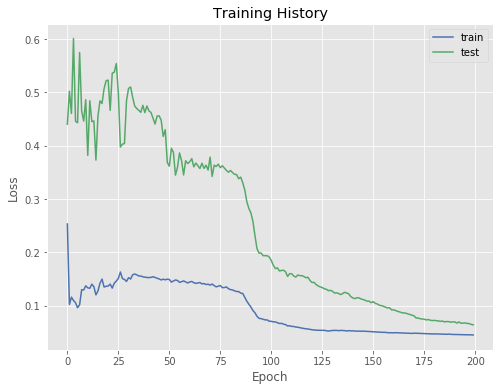

RMSE: 0.00013


RMSE: 0.00036


In [37]:
naive_rmse, fx_features_rmse = do_one_model('JPY', feature_col_names = ['JP_FX', 'JP_GDP', 'JP_UR', 'JP_CPI'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


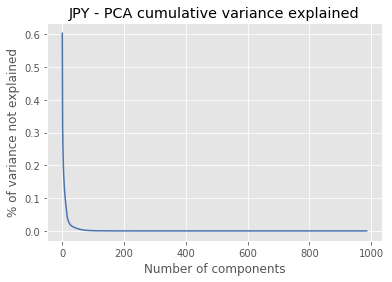

Cumulative variance explained by the first 93 components: 0.999


Reduced data shape: (4708, 94)


(3149, 1, 93) (3149,) (1552, 1, 93) (1552,)


Train on 3149 samples, validate on 1552 samples
Epoch 1/200
1s - loss: 0.4708 - val_loss: 0.9273
Epoch 2/200
0s - loss: 0.2003 - val_loss: 0.9838
Epoch 3/200
0s - loss: 0.2350 - val_loss: 0.9761
Epoch 4/200
0s - loss: 0.2032 - val_loss: 0.8298
Epoch 5/200
0s - loss: 0.2110 - val_loss: 0.2867
Epoch 6/200
0s - loss: 0.1598 - val_loss: 0.3596
Epoch 7/200
0s - loss: 0.1799 - val_loss: 0.3697
Epoch 8/200
0s - loss: 0.1536 - val_loss: 0.4430
Epoch 9/200
0s - loss: 0.1901 - val_loss: 0.2457
Epoch 10/200
0s - loss: 0.1444 - val_loss: 0.2633
Epoch 11/200
0s - loss: 0.1293 - val_loss: 0.2248
Epoch 12/200
0s - loss: 0.1263 - val_loss: 0.3917
Epoch 13/200
0s - loss: 0.1376 - val_loss: 0.1908
Epoch 14/200
0s - loss: 0.1265 - val_loss: 0.1597
Epoch 15/200
0s - loss: 0.1141 - val_loss: 0.1391
Epoch 16/200
0s - loss: 0.1075 - val_loss: 0.1288
Epoch 17/200
0s - loss: 0.1131 - val_loss: 0.1285
Epoch 18/200
0s - loss: 0.1084 - val_loss: 0.1623
Epoch 19/200
0s - loss: 0.1072 - val_loss: 0.3064
Epoch 20/20

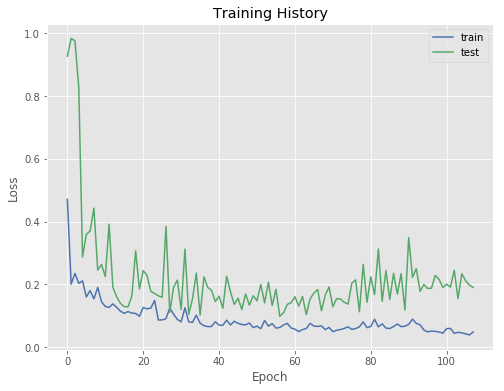

RMSE: 0.00012


RMSE: 0.0005


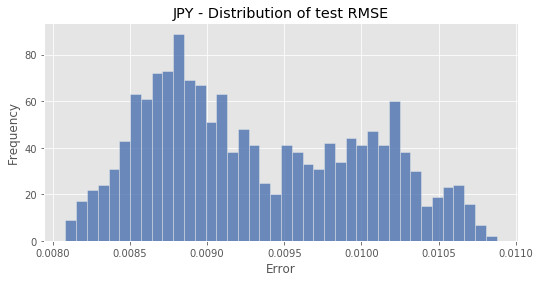

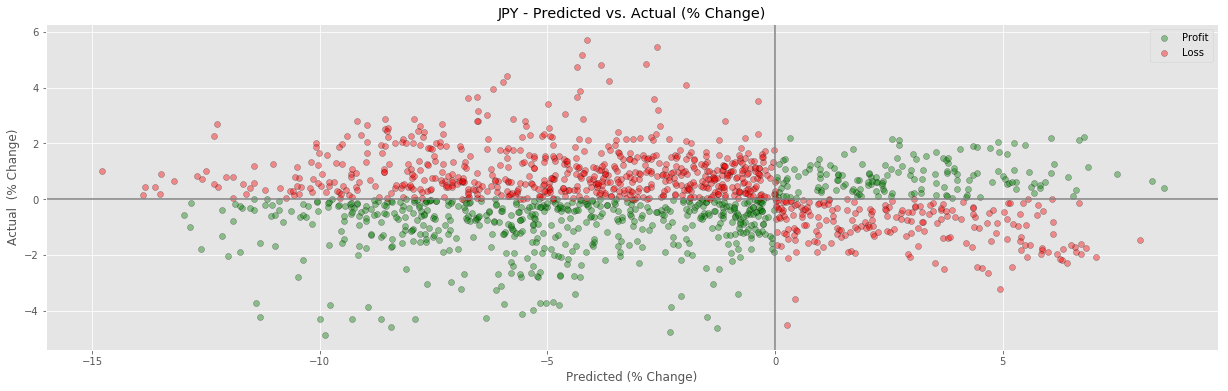

In [38]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('JP_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('JPY', feature_col_names = ['JP_FX'] + cols, do_pca = True)

In [39]:
all_results = accum_results(all_results, 'JPY', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## Switzerland

### FX rates only

In [40]:
naive_rmse, fx_rmse = do_one_model('CHF', feature_col_names = ['CH_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


CH_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


RMSE: 0.01446


RMSE: 0.01868


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


CH_FX, CH_INT_TB, CH_GDP, CH_CPI, CH_UR

Scaled data shape: (6551, 5)
Reframed data shape: (6538, 36)


CH_FX(t-7),CH_INT_TB(t-7),CH_GDP(t-7),CH_CPI(t-7),CH_UR(t-7),CH_FX(t-6),CH_INT_TB(t-6),CH_GDP(t-6),CH_CPI(t-6),CH_UR(t-6),CH_FX(t-5),CH_INT_TB(t-5),CH_GDP(t-5),CH_CPI(t-5),CH_UR(t-5),CH_FX(t-4),CH_INT_TB(t-4),CH_GDP(t-4),CH_CPI(t-4),CH_UR(t-4),CH_FX(t-3),CH_INT_TB(t-3),CH_GDP(t-3),CH_CPI(t-3),CH_UR(t-3),CH_FX(t-2),CH_INT_TB(t-2),CH_GDP(t-2),CH_CPI(t-2),CH_UR(t-2),CH_FX(t-1),CH_INT_TB(t-1),CH_GDP(t-1),CH_CPI(t-1),CH_UR(t-1),CH_FX(t+6)
0.777068,0.914547,0.811697,0.666667,0.191462,0.754884,0.915161,0.810766,0.666667,0.191040,0.751324,0.915774,0.809834,0.666667,0.190617,0.752602,0.916388,0.808903,0.666667,0.190194,0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.789483
0.754884,0.915161,0.810766,0.666667,0.191040,0.751324,0.915774,0.809834,0.666667,0.190617,0.752602,0.916388,0.808903,0.666667,0.190194,0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.767573,0.918843,0.805178,0.666667,0.188504,0.789438
0.751324,0.915774,0.809834,0.666667,0.190617,0.752602,0.916388,0.808903,0.666667,0.190194,0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.767573,0.918843,0.805178,0.666667,0.188504,0.758536,0.919457,0.804247,0.666667,0.188081,0.789301
0.752602,0.916388,0.808903,0.666667,0.190194,0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.767573,0.918843,0.805178,0.666667,0.188504,0.758536,0.919457,0.804247,0.666667,0.188081,0.763557,0.920071,0.803315,0.666667,0.187658,0.791400
0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.767573,0.918843,0.805178,0.666667,0.188504,0.758536,0.919457,0.804247,0.666667,0.188081,0.763557,0.920071,0.803315,0.666667,0.187658,0.767847,0.920685,0.802384,0.666667,0.187236,0.786836


(4375, 1, 35) (4375,) (2156, 1, 35) (2156,)


Train on 4375 samples, validate on 2156 samples
Epoch 1/200
1s - loss: 0.2610 - val_loss: 0.1238
Epoch 2/200
1s - loss: 0.1127 - val_loss: 0.0781
Epoch 3/200
1s - loss: 0.1108 - val_loss: 0.1579
Epoch 4/200
1s - loss: 0.1375 - val_loss: 0.1832
Epoch 5/200
1s - loss: 0.1446 - val_loss: 0.1480
Epoch 6/200
1s - loss: 0.1459 - val_loss: 0.1113
Epoch 7/200
1s - loss: 0.1422 - val_loss: 0.1263
Epoch 8/200
1s - loss: 0.1357 - val_loss: 0.1332
Epoch 9/200
1s - loss: 0.1295 - val_loss: 0.1160
Epoch 10/200
1s - loss: 0.1170 - val_loss: 0.2388
Epoch 11/200
1s - loss: 0.1149 - val_loss: 0.1334
Epoch 12/200
1s - loss: 0.1214 - val_loss: 0.2048
Epoch 13/200
1s - loss: 0.1095 - val_loss: 0.1611
Epoch 14/200
1s - loss: 0.1079 - val_loss: 0.1480
Epoch 15/200
1s - loss: 0.1268 - val_loss: 0.1128
Epoch 16/200
1s - loss: 0.1136 - val_loss: 0.0826
Epoch 17/200
1s - loss: 0.1137 - val_loss: 0.0652
Epoch 18/200
1s - loss: 0.1176 - val_loss: 0.0661
Epoch 19/200
1s - loss: 0.1071 - val_loss: 0.0810
Epoch 20/20

1s - loss: 0.0275 - val_loss: 0.0163
Epoch 164/200
1s - loss: 0.0276 - val_loss: 0.0156
Epoch 165/200
1s - loss: 0.0277 - val_loss: 0.0155
Epoch 166/200
1s - loss: 0.0276 - val_loss: 0.0159
Epoch 167/200
1s - loss: 0.0281 - val_loss: 0.0163
Epoch 168/200
1s - loss: 0.0284 - val_loss: 0.0179
Epoch 169/200
1s - loss: 0.0275 - val_loss: 0.0160
Epoch 170/200
1s - loss: 0.0277 - val_loss: 0.0153
Epoch 171/200
1s - loss: 0.0276 - val_loss: 0.0155
Epoch 172/200
1s - loss: 0.0283 - val_loss: 0.0166
Epoch 173/200
1s - loss: 0.0278 - val_loss: 0.0157
Epoch 174/200
1s - loss: 0.0273 - val_loss: 0.0151
Epoch 175/200
1s - loss: 0.0267 - val_loss: 0.0155
Epoch 176/200
1s - loss: 0.0268 - val_loss: 0.0153
Epoch 177/200
1s - loss: 0.0272 - val_loss: 0.0149
Epoch 178/200
1s - loss: 0.0275 - val_loss: 0.0157
Epoch 179/200
1s - loss: 0.0273 - val_loss: 0.0153
Epoch 180/200
1s - loss: 0.0272 - val_loss: 0.0148
Epoch 181/200
1s - loss: 0.0267 - val_loss: 0.0147
Epoch 182/200
1s - loss: 0.0265 - val_loss: 0

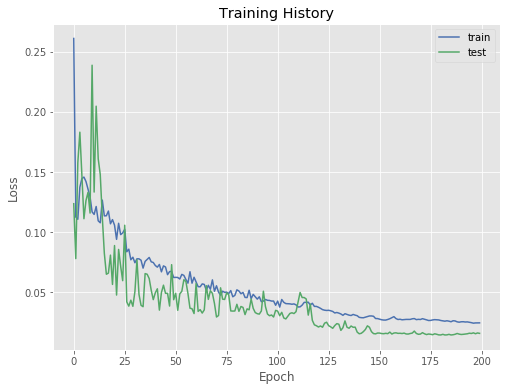

RMSE: 0.01446


RMSE: 0.01715


In [41]:
naive_rmse, fx_features_rmse = do_one_model('CHF', feature_col_names = \
    ['CH_FX', 'CH_INT_TB', 'CH_GDP', 'CH_CPI', 'CH_UR'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


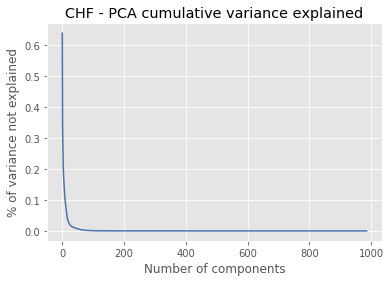

Cumulative variance explained by the first 93 components: 0.999


Reduced data shape: (4708, 94)


(3149, 1, 93) (3149,) (1552, 1, 93) (1552,)


Train on 3149 samples, validate on 1552 samples
Epoch 1/200
1s - loss: 0.5290 - val_loss: 1.1935
Epoch 2/200
0s - loss: 0.3201 - val_loss: 1.1299
Epoch 3/200
0s - loss: 0.1884 - val_loss: 0.7547
Epoch 4/200
0s - loss: 0.1964 - val_loss: 0.8307
Epoch 5/200
0s - loss: 0.1568 - val_loss: 0.3978
Epoch 6/200
0s - loss: 0.1402 - val_loss: 0.4414
Epoch 7/200
0s - loss: 0.1443 - val_loss: 0.6095
Epoch 8/200
0s - loss: 0.1377 - val_loss: 0.2889
Epoch 9/200
0s - loss: 0.1027 - val_loss: 0.3174
Epoch 10/200
0s - loss: 0.0791 - val_loss: 0.2378
Epoch 11/200
0s - loss: 0.1024 - val_loss: 0.2624
Epoch 12/200
0s - loss: 0.0845 - val_loss: 0.1889
Epoch 13/200
0s - loss: 0.0678 - val_loss: 0.2455
Epoch 14/200
0s - loss: 0.0669 - val_loss: 0.2272
Epoch 15/200
0s - loss: 0.0841 - val_loss: 0.1867
Epoch 16/200
0s - loss: 0.0827 - val_loss: 0.1423
Epoch 17/200
0s - loss: 0.0831 - val_loss: 0.2652
Epoch 18/200
0s - loss: 0.0916 - val_loss: 0.2430
Epoch 19/200
0s - loss: 0.0984 - val_loss: 0.1635
Epoch 20/20

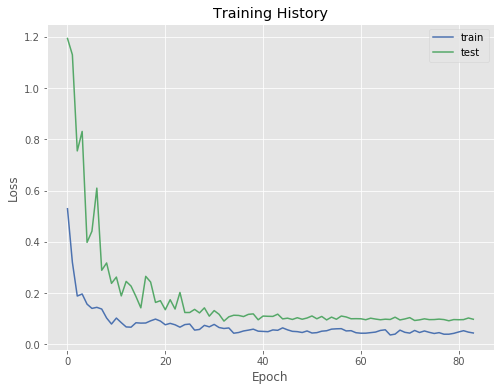

RMSE: 0.01558


RMSE: 0.04809


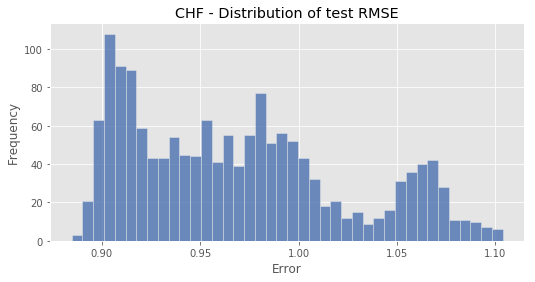

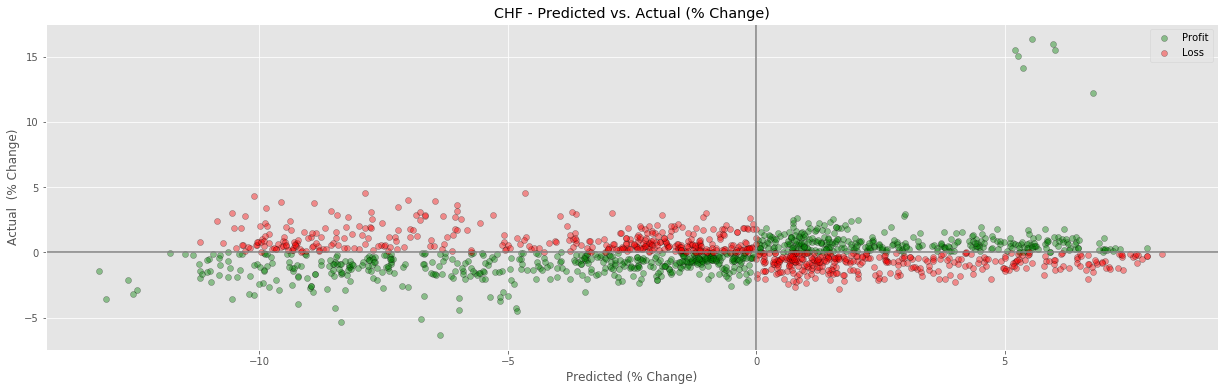

In [42]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CH_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('CHF', feature_col_names = ['CH_FX'] + cols, do_pca = True)

In [43]:
all_results = accum_results(all_results, 'CHF', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## UK

### FX rates only

In [44]:
naive_rmse, fx_rmse = do_one_model('GBP', feature_col_names = ['UK_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


UK_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


RMSE: 0.01748


RMSE: 0.03702


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


UK_FX, UK_GDP, US_INT_TB

Scaled data shape: (6551, 3)
Reframed data shape: (6538, 22)


UK_FX(t-7),UK_GDP(t-7),US_INT_TB(t-7),UK_FX(t-6),UK_GDP(t-6),US_INT_TB(t-6),UK_FX(t-5),UK_GDP(t-5),US_INT_TB(t-5),UK_FX(t-4),UK_GDP(t-4),US_INT_TB(t-4),UK_FX(t-3),UK_GDP(t-3),US_INT_TB(t-3),UK_FX(t-2),UK_GDP(t-2),US_INT_TB(t-2),UK_FX(t-1),UK_GDP(t-1),US_INT_TB(t-1),UK_FX(t+6)
0.462052,0.850790,0.864422,0.473181,0.850158,0.865626,0.478188,0.849526,0.866831,0.484865,0.848894,0.868035,0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.472290
0.473181,0.850158,0.865626,0.478188,0.849526,0.866831,0.484865,0.848894,0.868035,0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.473626,0.846365,0.872853,0.472791
0.478188,0.849526,0.866831,0.484865,0.848894,0.868035,0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.473626,0.846365,0.872853,0.485422,0.845732,0.874057,0.474293
0.484865,0.848894,0.868035,0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.473626,0.846365,0.872853,0.485422,0.845732,0.874057,0.483753,0.845100,0.875262,0.480748
0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.473626,0.846365,0.872853,0.485422,0.845732,0.874057,0.483753,0.845100,0.875262,0.485644,0.844468,0.876466,0.491876


(4375, 1, 21) (4375,) (2156, 1, 21) (2156,)


Train on 4375 samples, validate on 2156 samples
Epoch 1/200
1s - loss: 0.2328 - val_loss: 0.1669
Epoch 2/200
1s - loss: 0.1038 - val_loss: 0.1205
Epoch 3/200
1s - loss: 0.0927 - val_loss: 0.1289
Epoch 4/200
1s - loss: 0.1043 - val_loss: 0.1262
Epoch 5/200
1s - loss: 0.0961 - val_loss: 0.1728
Epoch 6/200
1s - loss: 0.1218 - val_loss: 0.1600
Epoch 7/200
1s - loss: 0.1102 - val_loss: 0.1775
Epoch 8/200
1s - loss: 0.1225 - val_loss: 0.1938
Epoch 9/200
1s - loss: 0.1023 - val_loss: 0.1857
Epoch 10/200
1s - loss: 0.0999 - val_loss: 0.1704
Epoch 11/200
1s - loss: 0.0941 - val_loss: 0.1659
Epoch 12/200
1s - loss: 0.1071 - val_loss: 0.1875
Epoch 13/200
1s - loss: 0.1166 - val_loss: 0.1850
Epoch 14/200
1s - loss: 0.1483 - val_loss: 0.1763
Epoch 15/200
1s - loss: 0.1182 - val_loss: 0.1749
Epoch 16/200
1s - loss: 0.1352 - val_loss: 0.1782
Epoch 17/200
1s - loss: 0.1335 - val_loss: 0.1525
Epoch 18/200
1s - loss: 0.1212 - val_loss: 0.1485
Epoch 19/200
1s - loss: 0.1120 - val_loss: 0.1626
Epoch 20/20

1s - loss: 0.0322 - val_loss: 0.0497
Epoch 164/200
1s - loss: 0.0324 - val_loss: 0.0497
Epoch 165/200
1s - loss: 0.0325 - val_loss: 0.0490
Epoch 166/200
1s - loss: 0.0326 - val_loss: 0.0439
Epoch 167/200
1s - loss: 0.0318 - val_loss: 0.0458
Epoch 168/200
1s - loss: 0.0321 - val_loss: 0.0459
Epoch 169/200
1s - loss: 0.0317 - val_loss: 0.0460
Epoch 170/200
1s - loss: 0.0316 - val_loss: 0.0461
Epoch 171/200
1s - loss: 0.0316 - val_loss: 0.0471
Epoch 172/200
1s - loss: 0.0320 - val_loss: 0.0511
Epoch 173/200
1s - loss: 0.0320 - val_loss: 0.0559
Epoch 174/200
1s - loss: 0.0323 - val_loss: 0.0520
Epoch 175/200
1s - loss: 0.0317 - val_loss: 0.0563
Epoch 176/200
1s - loss: 0.0325 - val_loss: 0.0526
Epoch 177/200
1s - loss: 0.0315 - val_loss: 0.0514
Epoch 178/200
1s - loss: 0.0316 - val_loss: 0.0509
Epoch 179/200
1s - loss: 0.0325 - val_loss: 0.0462
Epoch 180/200
1s - loss: 0.0314 - val_loss: 0.0481
Epoch 181/200
1s - loss: 0.0311 - val_loss: 0.0500
Epoch 182/200
1s - loss: 0.0312 - val_loss: 0

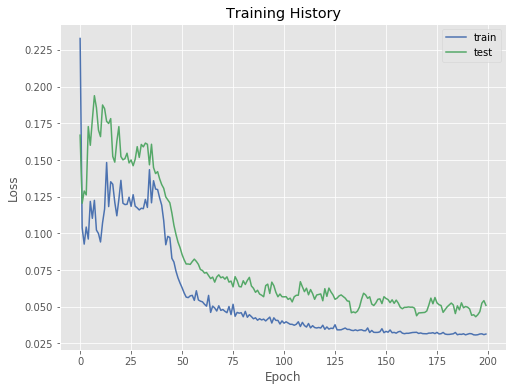

RMSE: 0.01748


RMSE: 0.05255


In [45]:
naive_rmse, fx_features_rmse = do_one_model('GBP', feature_col_names = ['UK_FX', 'UK_GDP', 'US_INT_TB'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


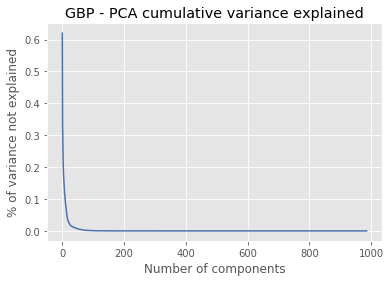

Cumulative variance explained by the first 93 components: 0.999


Reduced data shape: (4708, 94)


(3149, 1, 93) (3149,) (1552, 1, 93) (1552,)


Train on 3149 samples, validate on 1552 samples
Epoch 1/200
1s - loss: 0.4317 - val_loss: 1.2966
Epoch 2/200
0s - loss: 0.2523 - val_loss: 0.4796
Epoch 3/200
0s - loss: 0.2280 - val_loss: 0.6787
Epoch 4/200
0s - loss: 0.1773 - val_loss: 0.6259
Epoch 5/200
0s - loss: 0.1327 - val_loss: 0.4084
Epoch 6/200
0s - loss: 0.1426 - val_loss: 0.4233
Epoch 7/200
0s - loss: 0.1191 - val_loss: 0.2337
Epoch 8/200
0s - loss: 0.1236 - val_loss: 0.3259
Epoch 9/200
0s - loss: 0.1021 - val_loss: 0.1920
Epoch 10/200
0s - loss: 0.0837 - val_loss: 0.2274
Epoch 11/200
0s - loss: 0.0636 - val_loss: 0.1747
Epoch 12/200
0s - loss: 0.0716 - val_loss: 0.3486
Epoch 13/200
0s - loss: 0.1079 - val_loss: 0.1879
Epoch 14/200
0s - loss: 0.0854 - val_loss: 0.1520
Epoch 15/200
0s - loss: 0.0845 - val_loss: 0.1196
Epoch 16/200
0s - loss: 0.1104 - val_loss: 0.1348
Epoch 17/200
0s - loss: 0.0892 - val_loss: 0.1747
Epoch 18/200
0s - loss: 0.0671 - val_loss: 0.1456
Epoch 19/200
0s - loss: 0.0668 - val_loss: 0.1404
Epoch 20/20

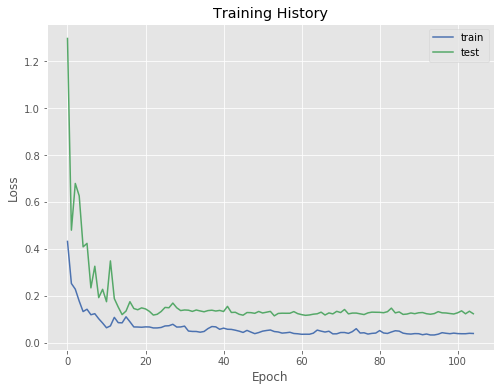

RMSE: 0.01834


RMSE: 0.11099


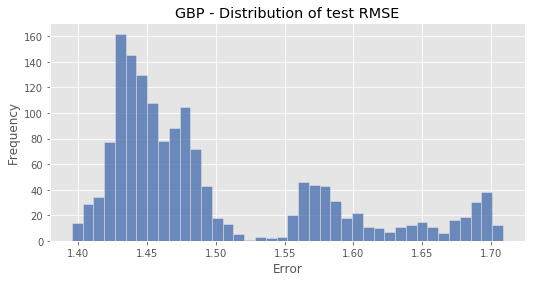

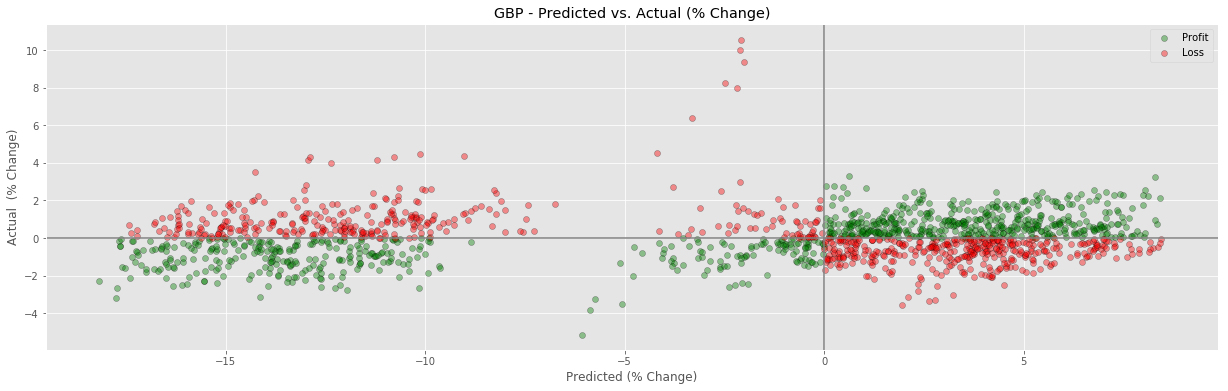

In [46]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('UK_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('GBP', feature_col_names = ['UK_FX'] + cols, do_pca = True)

In [47]:
all_results = accum_results(all_results, 'GBP', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

# Summary of results

#### Test RMSE for all FX rates (relative to USD)

In [48]:
all_results = all_results[['Currency', 'Naive', 'FX Only', 'FX + Features', 'All Features']]
all_results.to_csv('RMSE_LSTM_7.csv', index = False)

pd.options.display.float_format = '{:,.5f}'.format
my_linespace()
my_display_df(all_results)

Currency,Naive,FX Only,FX + Features,All Features
AUD,0.01038,0.02661,0.03426,0.03466
CAD,0.00873,0.01523,0.01399,0.02792
EUR,0.01347,0.02098,0.03526,0.03378
JPY,0.00012,0.00023,0.00036,0.00050
CHF,0.01558,0.01868,0.01715,0.04809
GBP,0.01834,0.03702,0.05255,0.11099


#### Test RMSE as a share of naive RMSE for all FX rates (relative to USD)

In [49]:
pd.options.display.float_format = '{:,.2f}'.format

all_results_2 = all_results.drop('Naive', axis = 1)
all_results_2['FX Only'] = np.round(all_results['FX Only'] / all_results['Naive'], 3)
all_results_2['FX + Features'] = np.round(all_results['FX + Features'] / all_results['Naive'], 3)
all_results_2['All Features'] = np.round(all_results['All Features'] / all_results['Naive'], 3)
all_results_2 = all_results_2[['Currency', 'FX Only', 'FX + Features', 'All Features']]
all_results_2.to_csv('Test_Naive_LSTM_7.csv', index = False)

my_linespace()
my_display_df(all_results_2)

Currency,FX Only,FX + Features,All Features
AUD,2.56,3.30,3.34
CAD,1.74,1.60,3.20
EUR,1.56,2.62,2.51
JPY,1.89,3.01,4.16
CHF,1.20,1.10,3.09
GBP,2.02,2.87,6.05


#### Visualize test RMSE as a share of naive RMSE

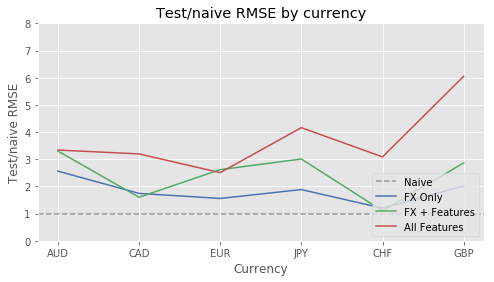

In [50]:
n_items = all_results.shape[0]

print()
fig, ax = plt.subplots(figsize = (8, 4))

ax.axhline(y = 1.0, color = '0.6', linestyle = '--', label = 'Naive')

ax.plot(range(n_items), all_results_2['FX Only'], label = 'FX Only')
ax.plot(range(n_items), all_results_2['FX + Features'], label = 'FX + Features')
ax.plot(range(n_items), all_results_2['All Features'], label = 'All Features')

ax.set_ylim((0.0, 8.0))
ax.set_xticks(range(n_items))
ax.set_xticklabels(all_results_2['Currency'])

ax.set_xlabel('Currency')
ax.set_ylabel('Test/naive RMSE')
ax.set_title('Test/naive RMSE by currency')

plt.legend(loc = 'lower right')
plt.show()